# Hands-On NLP
## Class 3

<span style="color:magenta">Group Names:</span>

* Zhe HUANG
* Pierre QIU
* Lanshi FU

### Outline

- Better vectors : Tf-idf

- Ngrams

- Text generation

In [2]:
import re
import collections
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn import decomposition, naive_bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm

In [3]:
tqdm.pandas()

nltk.download("punkt")

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 4)

print("sklearn's version:", sklearn.__version__)    # 1.2.0
print("nltk's version:", nltk.__version__)          # 3.8.1
print("pandas's version:", pd.__version__)          # 1.5.2

sklearn's version: 1.2.0
nltk's version: 3.8.1
pandas's version: 1.5.2


[nltk_data] Downloading package punkt to /Users/zhehuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
%config InlineBackend.figure_format="retina"  # For high DPI display

# Getting the data

In [5]:
DATA = Path("data")

TEXT_P = DATA / "texts"

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

In [6]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [7]:
all_df = pd.DataFrame.from_records(data, index=["id"])
all_df = all_df.drop("robotics.stackexchange_0000005103")
all_df

,text,category,cat_id
id,,,
mythology.stackexchange_0000001634,Q:\n\nCan anyone identify what Chinese mytholo...,mythology,0
mythology.stackexchange_0000002329,Q:\n\nHave runes ever been used to bring someo...,mythology,0
mythology.stackexchange_0000001146,Q:\n\nDifferences in the Greek and Roman portr...,mythology,0
mythology.stackexchange_0000004770,"Q:\n\nWhich cultures have the concept of a ""tr...",mythology,0
mythology.stackexchange_0000000516,Q:\n\nWhy did Arawn choose Pwyll to fight Hafg...,mythology,0
...,...,...,...
portuguese.stackexchange_0000001017,"Q:\n\n""pois não"" has an affirmative connotatio...",portuguese,5
portuguese.stackexchange_0000004609,"Q:\n\nPor que ""Teiú"" tem acento?\n\nMonossílab...",portuguese,5
portuguese.stackexchange_0000000484,"Q:\n\nRegional usage of ""guitarra"" and ""violão...",portuguese,5


---
Here the initialization of `all_df` is done and you can jump to your favorite classification
___

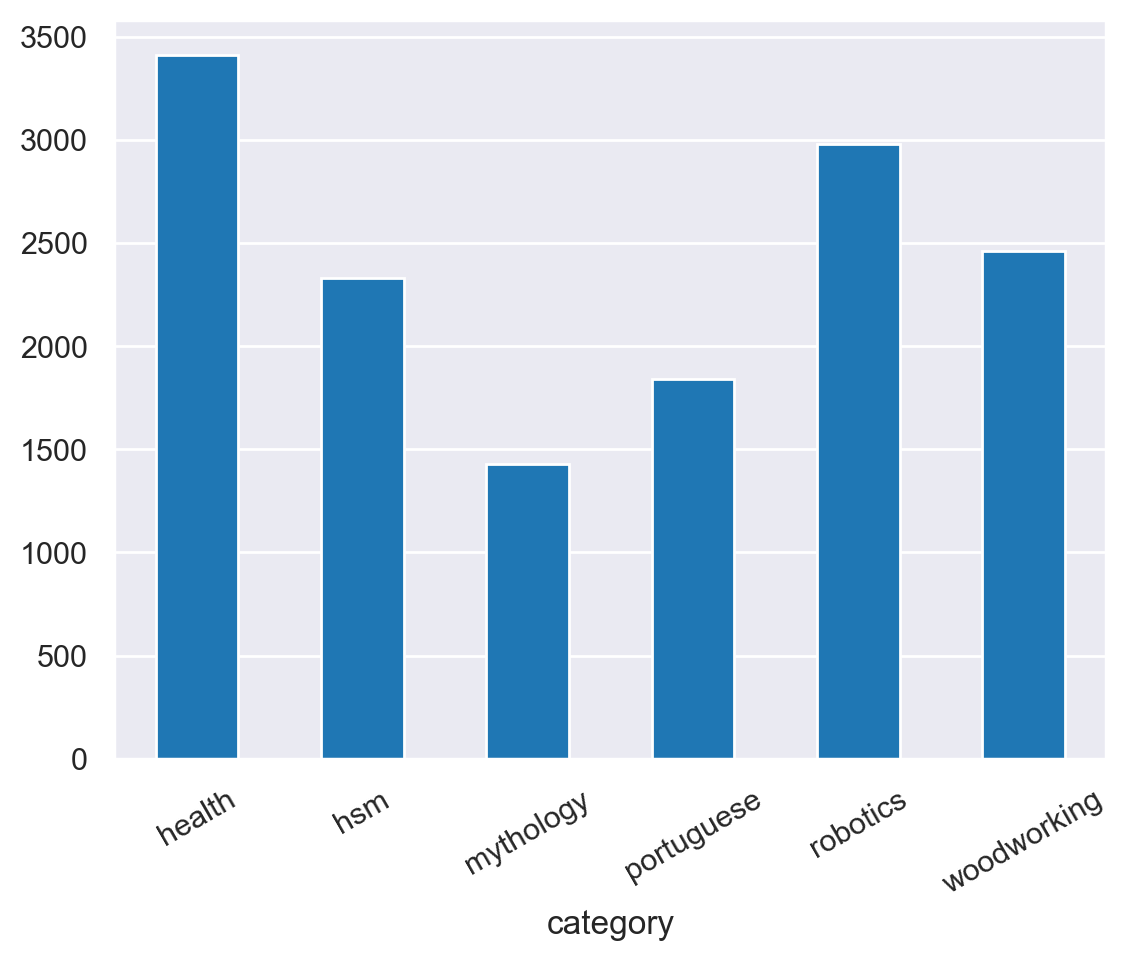

In [8]:
all_df.groupby("category").size().plot.bar()
plt.xticks(rotation=30)
plt.grid(axis="x")

# Vectorizers

In [9]:
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(corpus).toarray()

cv_df = pd.DataFrame(xs, index=corpus, columns=vectorizer.get_feature_names_out())
cv_df

,and,document,first,is,one,second,the,third,this
This is the first document.,0,1,1,1,0,0,1,0,1
This document is the second document.,0,2,0,1,0,1,1,0,1
And this is the third one.,1,0,0,1,1,0,1,1,1
Is this the first document?,0,1,1,1,0,0,1,0,1


In [10]:
tf_idf = TfidfVectorizer()
xs = tf_idf.fit_transform(corpus).toarray()

tf_idf_df = pd.DataFrame(xs, index=corpus, columns=tf_idf.get_feature_names_out())
tf_idf_df

,and,document,first,is,one,second,the,third,this
This is the first document.,0.0000,0.4698,0.5803,0.3841,0.0000,0.0000,0.3841,0.0000,0.3841
This document is the second document.,0.0000,0.6876,0.0000,0.2811,0.0000,0.5386,0.2811,0.0000,0.2811
And this is the third one.,0.5118,0.0000,0.0000,0.2671,0.5118,0.0000,0.2671,0.5118,0.2671
Is this the first document?,0.0000,0.4698,0.5803,0.3841,0.0000,0.0000,0.3841,0.0000,0.3841


$$\operatorname{tf}(t,d) = \frac{f_{t,d}}{{\sum_{t' \in d}{f_{t',d}}}}$$

$$\operatorname{idf}(t, D) = \log \left( \frac {N} {1 + n_t}\right)+ 1$$


<font color=orange>

**$tf$: term frequency**  
$f_{t,d}$: freqency of word $t$ in document $d$  

**$idf$: inverse document frequency**  
$N$: number of documents  
$n_{t}$: number of documents containing word $t$  

**$tf-idf = tf * idf$**
<font>

### Getting back to the complete corpus: `all_df`

In [11]:
ys = all_df.cat_id.values

In [12]:
%%time

cv = CountVectorizer(max_features=5000)
xs = cv.fit_transform(all_df.text).toarray()

CPU times: user 3.44 s, sys: 172 ms, total: 3.61 s
Wall time: 3.62 s


In [13]:
print("xs.shape =", xs.shape)
print("ys.shape =", ys.shape)

xs.shape = (14450, 5000)
ys.shape = (14450,)


In [14]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(10115, 5000)
(4335, 5000)


#### 🚧 TODO: `CountVectorizer` vs. `TfidfVectorizer` classifiers

*   Limit to the 5000 most frequent words to reduce the dimensionality

    (the sparse matrix `toarray()` method crashes if no reduction of features is applied)

*   Use both to classify the data based on, e.g., the `MultinomialNB` classifier

*   Compare their results in terms of accuracy and show their `classification_report`

# CountVectorizer situation

In [15]:
# we use MultinomialNB classifier
model = naive_bayes.MultinomialNB()

model.fit(X=train_xs, y=train_ys)
y_pred = model.predict(test_xs)

acc_cv = accuracy_score(y_true = test_ys, y_pred=y_pred)

In [16]:
print(classification_report(y_true = test_ys, y_pred=y_pred, target_names=CORPORA))

              precision    recall  f1-score   support

   mythology       0.95      0.99      0.97       420
 woodworking       0.97      1.00      0.98       692
    robotics       0.98      0.97      0.98       935
         hsm       0.95      0.97      0.96       709
      health       0.98      0.98      0.98      1054
  portuguese       1.00      0.93      0.96       525

    accuracy                           0.97      4335
   macro avg       0.97      0.97      0.97      4335
weighted avg       0.97      0.97      0.97      4335



# TfidfVectorizer situation

In [17]:
%%time

tf_idf = TfidfVectorizer(max_features=5000)
xs = tf_idf.fit_transform(all_df.text).toarray()


CPU times: user 3.61 s, sys: 328 ms, total: 3.94 s
Wall time: 3.48 s


In [18]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)

model = naive_bayes.MultinomialNB()

model.fit(X=train_xs, y=train_ys)
y_pred = model.predict(test_xs)

acc_tfidf = accuracy_score(y_true=test_ys, y_pred=y_pred)
print(classification_report(y_true=test_ys, y_pred=y_pred, target_names=CORPORA))

              precision    recall  f1-score   support

   mythology       0.97      0.96      0.97       420
 woodworking       0.97      1.00      0.98       692
    robotics       0.97      0.98      0.98       935
         hsm       0.95      0.97      0.96       709
      health       0.98      0.99      0.99      1054
  portuguese       1.00      0.93      0.97       525

    accuracy                           0.97      4335
   macro avg       0.98      0.97      0.97      4335
weighted avg       0.98      0.97      0.97      4335



# Comparison in terms of accuracy

In [19]:
print("Using modle MultinomialNB")
print("accuracy of CountVectorizer situation:", acc_cv)
print("accuracy of TfidfVectorizer situation:", acc_tfidf)

Using modle MultinomialNB
accuracy of CountVectorizer situation: 0.9741637831603229
accuracy of TfidfVectorizer situation: 0.9748558246828143


#### 🚧 TODO: `MultinomialNB` vs. `GaussianNB` classifiers

*   Use both to classify the data

*   Compare their results in terms of accuracy and show their `classification_report`

# MultinomialNB situation

In [20]:
# as can be seen in cells above, we used MultinomialNB as model and chose tfidfVectorizer
acc_MultinomialNB = accuracy_score(y_true=test_ys, y_pred=y_pred)
print(classification_report(y_true=test_ys, y_pred=y_pred, target_names=CORPORA))


              precision    recall  f1-score   support

   mythology       0.97      0.96      0.97       420
 woodworking       0.97      1.00      0.98       692
    robotics       0.97      0.98      0.98       935
         hsm       0.95      0.97      0.96       709
      health       0.98      0.99      0.99      1054
  portuguese       1.00      0.93      0.97       525

    accuracy                           0.97      4335
   macro avg       0.98      0.97      0.97      4335
weighted avg       0.98      0.97      0.97      4335



# GaussianNB situation

In [21]:
model = naive_bayes.GaussianNB()

model.fit(X=train_xs, y=train_ys)
y_pred = model.predict(test_xs)

acc_GaussianNB = accuracy_score(y_true=test_ys, y_pred=y_pred)
print(classification_report(y_true=test_ys, y_pred=y_pred, target_names=CORPORA))

              precision    recall  f1-score   support

   mythology       0.95      0.94      0.94       420
 woodworking       0.97      0.96      0.96       692
    robotics       0.97      0.95      0.96       935
         hsm       0.90      0.92      0.91       709
      health       0.94      0.98      0.96      1054
  portuguese       0.99      0.97      0.98       525

    accuracy                           0.95      4335
   macro avg       0.95      0.95      0.95      4335
weighted avg       0.95      0.95      0.95      4335



# Comparison in terms of accuracy

In [22]:
print("Choosing TfidfVectorizer")
print("accuracy of MultinomialNB situation:", acc_MultinomialNB)
print("accuracy of GaussianNB situation:", acc_GaussianNB)

Choosing TfidfVectorizer
accuracy of MultinomialNB situation: 0.9748558246828143
accuracy of GaussianNB situation: 0.952479815455594


#### 🚧 TODO: Confusion matrix

- Verify in a confusion matrix that the precision of portuguese is 1.00 and its recall is about 0.93 with the `MultinomialNB` classifier on the Tfidf vectorizer

- Translate this result into a sentence

In [23]:
ys = all_df.cat_id.values

tf_idf = TfidfVectorizer(max_features=5000)
xs = tf_idf.fit_transform(all_df.text).toarray()

train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)

model = naive_bayes.MultinomialNB()
model.fit(X=train_xs, y=train_ys)
y_pred = model.predict(test_xs)

In [24]:
print(classification_report(y_true = test_ys, y_pred=y_pred, target_names=CORPORA))

              precision    recall  f1-score   support

   mythology       0.97      0.96      0.97       420
 woodworking       0.97      1.00      0.98       692
    robotics       0.97      0.98      0.98       935
         hsm       0.95      0.97      0.96       709
      health       0.98      0.99      0.99      1054
  portuguese       1.00      0.93      0.97       525

    accuracy                           0.97      4335
   macro avg       0.98      0.97      0.97      4335
weighted avg       0.98      0.97      0.97      4335



In [25]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=test_ys, y_pred=y_pred), index=CORPORA, columns=CORPORA)
confusion_matrix_df

,mythology,woodworking,robotics,hsm,health,portuguese
mythology,405,1,0,13,1,0
woodworking,0,690,1,0,1,0
robotics,0,15,913,2,5,0
hsm,4,0,12,687,6,0
health,0,6,5,2,1041,0
portuguese,8,1,6,17,3,490


<font color=orange>

From the confusion matrix, we can know two things.  

On one side: 
There are $8+1+6+17+3+490 = 525$ portuguese texts; 
$8$ portuguese texts are wrongly classified into mythology; 
$1$ portuguese texts are wrongly classified into woodworking; 
$6$ portuguese texts are wrongly classified into robotics; 
$17$ portuguese texts are wrongly classified into hsm; 
$3$ portuguese texts are wrongly classified into health; 
$490$ portuguese texts are correctly classified into portuguese.  

Thus we got **Recall** by calcul: $490/525 = 0.93$  

On the other side:
No texts are wrongly classified into portuguese.  

Thus we got **Precision** by calcul: $490/490 = 1.0$
<font>

<font color=orange>

In a word, $Precision==1.0$ means: No texts are wrongly classified into portuguese; $Recall==0.93$ means: $93\%$ of portugueses are correctly classfied. 
<font>

#### 🚧 TODO: add the `stop_words="english"` option to the `tf_idf` vectorizer 

*   Compare the size of the sparse_xs for the 2 conditions (stop words included or not) without limiting to the 5000 features

*   Retrain with the new vectorizer and the MultinomialNB classifier

*   Compare the results with the previous vectorizer

In [26]:
print('without limiting to the 5000 features')

tf_idf = TfidfVectorizer(stop_words="english")
xs = tf_idf.fit_transform(all_df.text).toarray()
print("stop words inclued, sparse_xs's shape is", xs.shape)

tf_idf = TfidfVectorizer()
xs = tf_idf.fit_transform(all_df.text).toarray()
print("stop words not inclued, sparse_xs's shape is", xs.shape)

without limiting to the 5000 features
stop words inclued, sparse_xs's shape is (14450, 152763)
stop words not inclued, sparse_xs's shape is (14450, 153076)


<font color=orange>
We can see that adding the parameter stop_words filtered some features.
<font>

In [27]:
tf_idf = TfidfVectorizer(stop_words="english", max_features=5000)
xs = tf_idf.fit_transform(all_df.text).toarray()

train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)

model = naive_bayes.MultinomialNB()
model.fit(X=train_xs, y=train_ys)
y_pred = model.predict(test_xs)

In [28]:
print(classification_report(y_true = test_ys, y_pred=y_pred, target_names=CORPORA))

              precision    recall  f1-score   support

   mythology       0.97      0.97      0.97       420
 woodworking       0.97      1.00      0.98       692
    robotics       0.97      0.98      0.97       935
         hsm       0.96      0.96      0.96       709
      health       0.99      0.98      0.98      1054
  portuguese       1.00      0.96      0.98       525

    accuracy                           0.98      4335
   macro avg       0.98      0.97      0.98      4335
weighted avg       0.98      0.98      0.98      4335



<font color=orange>

Using TfidfVectorizer, limiting to 5000 features, we can compare the two results stop words inclued or not:  

Accuracy without stop words is 0.97 while accuracy with stop words is 0.98;  

Besides, some values, like robotics's f1-score, decreased a little bit.
<font>

#### 🚧 TODO: PCA

*   Apply PCA to project on 2 dimensions to all vectors (train and test) and plot them

*   Compare the plot with the previous vectorizer with, and without the `stop_words="english"` option

*   Explain the difference breafly

# 2-dimension PCA plot (using TfidfVectorizer limited to 5000 features) with stop_words='english'

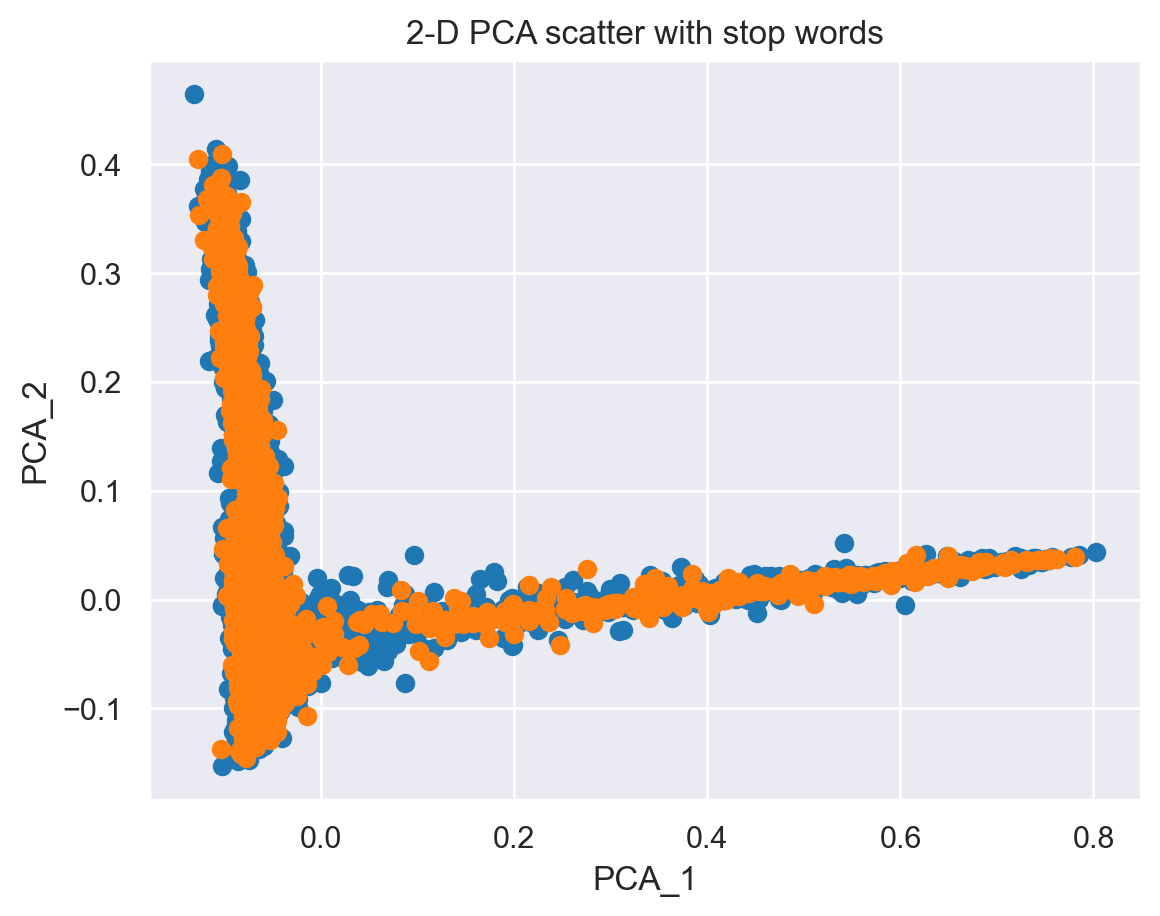

In [29]:
pca = decomposition.PCA(n_components=2)
train_xs_decomposed = pca.fit_transform(train_xs)
test_xs_decomposed = pca.transform(test_xs)

plt.scatter(train_xs_decomposed.T[0], train_xs_decomposed.T[1])
plt.scatter(test_xs_decomposed.T[0], test_xs_decomposed.T[1])
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.title('2-D PCA scatter with stop words')
plt.show()


# 2-dimension PCA plot (using TfidfVectorizer limited to 5000 features) without stop_words='english'

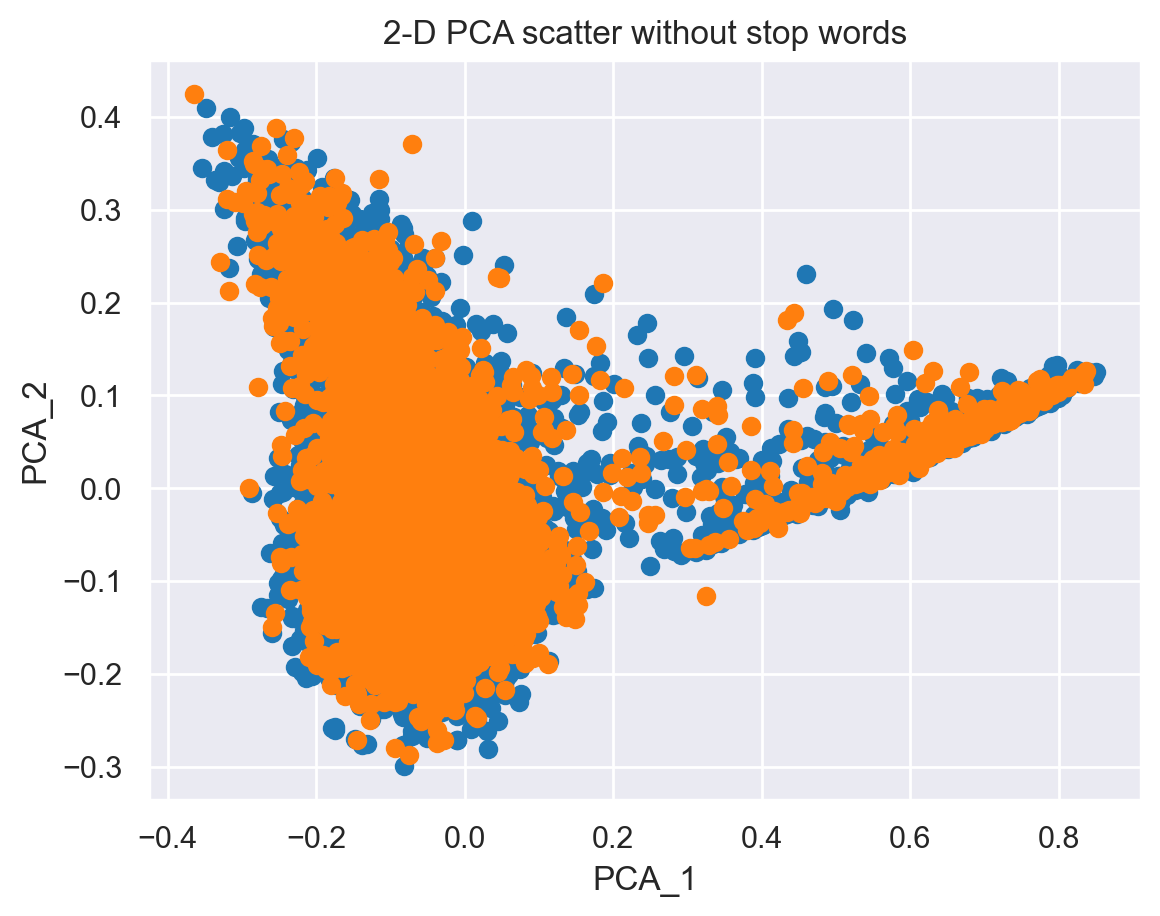

In [30]:
tf_idf = TfidfVectorizer(max_features=5000)
xs = tf_idf.fit_transform(all_df.text).toarray()

train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)

pca = decomposition.PCA(n_components=2)
train_xs_decomposed = pca.fit_transform(train_xs)
test_xs_decomposed = pca.transform(test_xs)

plt.scatter(train_xs_decomposed.T[0], train_xs_decomposed.T[1])
plt.scatter(test_xs_decomposed.T[0], test_xs_decomposed.T[1])
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.title('2-D PCA scatter without stop words')
plt.show()

<font color=orange>

The parameter stop_words='english' filiterd features like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text.  

Once the useless information got removed, the 2-D PCA scatter plot became less discrete.  

That's why the first plot seems more reasonable.
<font>

#### 🚧 TODO: Train on PCA

*   Apply PCA to project on 2 dimensions to all vectors (train and test), fitting the PCA only on the training set

*   Train the MultinomialNB and the GaussianNB classifiers on the PCA vectors

    *   Does it work with both classifiers? Explain breafly.

*   Compare the results with the vectorizer with, and without, the `stop_words="english"` option

*   Analyze the difference breafly

# With stop_words="english"

In [31]:
tf_idf = TfidfVectorizer(max_features=5000, stop_words="english")
xs = tf_idf.fit_transform(all_df.text).toarray()

train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)

pca = decomposition.PCA(n_components=2)
train_xs_decomposed = pca.fit_transform(train_xs)
test_xs_decomposed = pca.transform(test_xs)


<font color=orange>

When we use MultinomialNB after PCA decomposition, there will be an error:  

**ValueError: Negative values in data passed to MultinomialNB (input X)**  

That's because after PCA, train_xs_decomposed will contain negative values.
<font>


In [32]:
model = naive_bayes.GaussianNB()
model.fit(X=train_xs_decomposed, y=train_ys)
y_pred = model.predict(test_xs_decomposed)
acc_MultinomialNB = accuracy_score(y_true=test_ys, y_pred=y_pred)
acc_GaussianNB = accuracy_score(y_true=test_ys, y_pred=y_pred)
print("accuracy of GaussianNB situation:", acc_GaussianNB)

accuracy of GaussianNB situation: 0.6403690888119954


# Without stop_words="english"

In [33]:
tf_idf = TfidfVectorizer(max_features=5000)
xs = tf_idf.fit_transform(all_df.text).toarray()

train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)

pca = decomposition.PCA(n_components=2)
train_xs_decomposed = pca.fit_transform(train_xs)
test_xs_decomposed = pca.transform(test_xs)

In [93]:
model = naive_bayes.GaussianNB()
model.fit(X=train_xs_decomposed, y=train_ys)
y_pred = model.predict(test_xs_decomposed)
acc_GaussianNB = accuracy_score(y_true=test_ys, y_pred=y_pred)
print("accuracy of GaussianNB situation:", acc_GaussianNB)

accuracy of GaussianNB situation: 0.5787773933102652


<font color=orange>

After removing the parameter stop_words="english", the accuracy decreased from 0.64 to 0.58.  

This is because the parameter stop_words='english' filiterd features like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text.  
<font>

#### 🚧 TODO: PCA with more dimensions

*   Try to find the best number of dimensions for the PCA with [`GridSearchCV`](sklearn.model_selection.GridSearchCV)

*   Use pipeline to combine the PCA and the classifier and other potential preprocessing steps

*   Boxplot accuracyies for different PCA dimension values using 

In [76]:
tf_idf = TfidfVectorizer(max_features=5000, stop_words="english")
xs = tf_idf.fit_transform(all_df.text).toarray()

train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)

# grid search parameter for PCA
# param_grid = {"pca__n_components": [2, 5, 7, 10, 15, 30, 50, 100, 200, 300, 500]} #### the first time we find the best number of dim is 7
param_grid = {"pca__n_components": np.linspace(1,50, 50).astype(int)} #### so the second time we can cheat a little to get a fancy boxplot

# pipeline combining PCA and GaussianNB
pipe = Pipeline(steps=[("pca", decomposition.PCA()), ("model", naive_bayes.GaussianNB())])

grid = GridSearchCV(
    pipe, param_grid=param_grid, n_jobs=-1, verbose=3, cv=5
)
grid.fit(train_xs, train_ys)
y_pred = grid.best_estimator_.predict(test_xs)

print(grid.best_estimator_)
print('best score:', grid.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 2/5] END ...............pca__n_components=2;, score=0.656 total time=   4.1s
[CV 3/5] END ...............pca__n_components=1;, score=0.481 total time=   4.1s
[CV 2/5] END ...............pca__n_components=1;, score=0.462 total time=   4.2s
[CV 5/5] END ...............pca__n_components=1;, score=0.459 total time=   4.2s
[CV 1/5] END ...............pca__n_components=1;, score=0.464 total time=   4.2s
[CV 4/5] END ...............pca__n_components=1;, score=0.447 total time=   4.4s
[CV 1/5] END ...............pca__n_components=2;, score=0.643 total time=   4.4s
[CV 3/5] END ...............pca__n_components=2;, score=0.659 total time=   4.5s
[CV 4/5] END ...............pca__n_components=2;, score=0.624 total time=   2.4s
[CV 5/5] END ...............pca__n_components=2;, score=0.631 total time=   2.5s
[CV 4/5] END ...............pca__n_components=3;, score=0.817 total time=   4.1s
[CV 1/5] END ...............pca__n_components=4

In [86]:
print("accuracy with best PCA dimension 7 in test set:", accuracy_score(y_true=test_ys, y_pred=y_pred))

accuracy with best PCA dimension 7 in test set: 0.9552479815455595


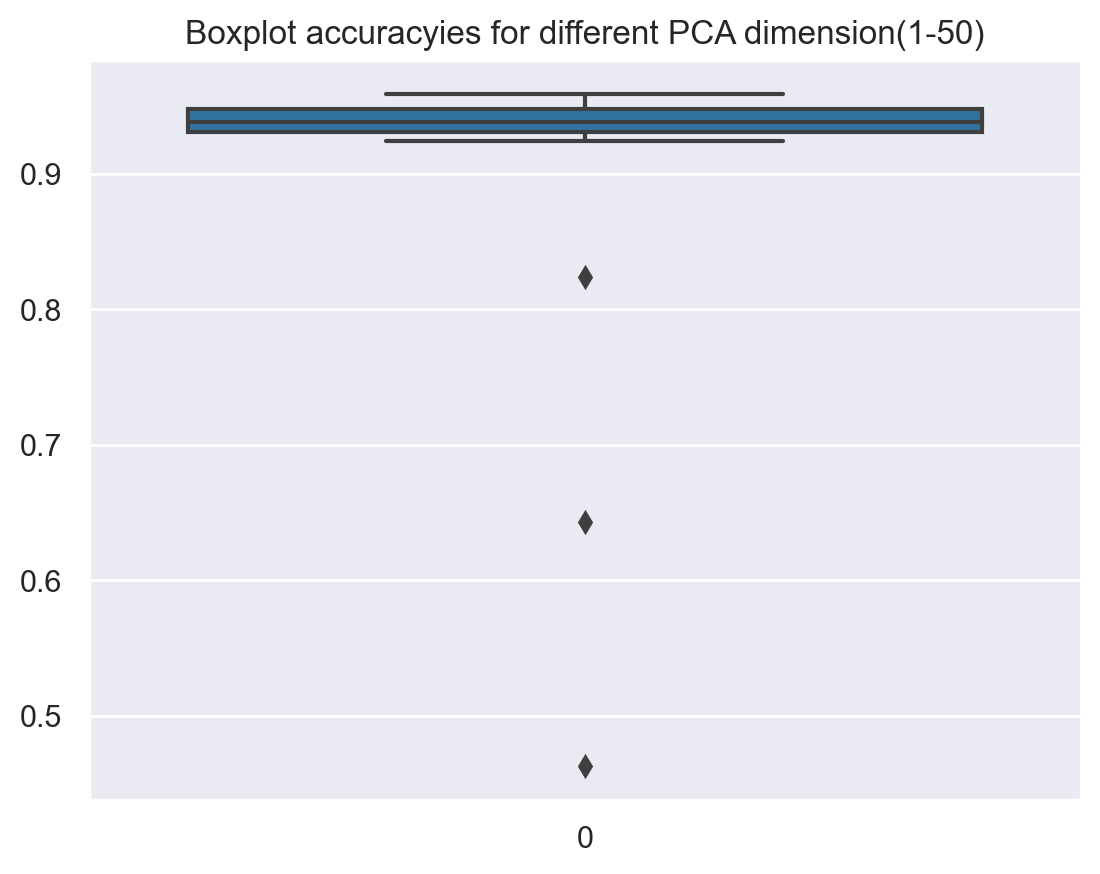

In [87]:
sns.boxplot(grid.cv_results_['mean_test_score'])
plt.title('Boxplot accuracyies for different PCA dimension(1-50)')
plt.show()

## N-grams

In [88]:
# %%time

vectorizer_2g = CountVectorizer(
    analyzer="word", ngram_range=(2, 2), max_features=5000,
)
x2gs = vectorizer_2g.fit_transform(all_df.text).toarray()

In [89]:
pd.DataFrame(vectorizer_2g.get_feature_names_out(), columns=["bigrams"])

,bigrams
0,17th century
1,18th century
2,19th century
3,20th century
4,24 hours
...,...
4995,your question
4996,your robot
4997,your system
4998,youtube com


In [90]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    x2gs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(10115, 5000)
(4335, 5000)


#### 🚧 TODO: Train on Ngrams

*   Train on the `CountVectorizer` with ngrams using the `MultinomialNB` classifier

*   Compare the results with the previous "raw" `CountVectorizer`

In [99]:
model = naive_bayes.MultinomialNB()
model.fit(X=train_xs, y=train_ys)
y_pred = model.predict(test_xs)
acc_MultinomialNB = accuracy_score(y_true=test_ys, y_pred=y_pred)
print("using MultinomialNB on 2-gram CountVectorizer, the accuracy is", acc_MultinomialNB)

using MultinomialNB on 2-gram CountVectorizer, the accuracy is 0.9370242214532872


<font color=orange>  

As alrady done above, using MultinomialNB on 1-gram CountVectorizer, the accuracy is 0.9741637831603229.  

Compared with 1-gram situation, although 2-gram brings more constraints, its prediction is less reliable.
<font>

---
## Building an n-gram generator
___

### Let's build character trigrams first

In [100]:
LINE = "This is cool!"
N = 3
[LINE[i : i + N] for i in range(len(LINE) - N + 1)]

['Thi', 'his', 'is ', 's i', ' is', 'is ', 's c', ' co', 'coo', 'ool', 'ol!']

In [101]:
[tuple(LINE[i : i + N]) for i in range(len(LINE) - N + 1)]

[('T', 'h', 'i'),
 ('h', 'i', 's'),
 ('i', 's', ' '),
 ('s', ' ', 'i'),
 (' ', 'i', 's'),
 ('i', 's', ' '),
 ('s', ' ', 'c'),
 (' ', 'c', 'o'),
 ('c', 'o', 'o'),
 ('o', 'o', 'l'),
 ('o', 'l', '!')]

In [102]:
LINES = """This is cool!
This is amazing!
But why is this his fish?"""

re.split("\n+", LINES.lower())

['this is cool!', 'this is amazing!', 'but why is this his fish?']

In [106]:
ngrams = collections.Counter()
for line in re.split("\n+", LINES.lower()):
    ngrams.update([line[i : i + N] for i in range(len(line) - N + 1)])
print(ngrams)

nc_df = pd.DataFrame.from_dict(
    ngrams, orient="index", columns=["freq"]
).sort_values("freq", ascending=False)

nc_df.head(7)

Counter({'is ': 7, 'his': 4, 'thi': 3, ' is': 3, 's i': 2, 's c': 1, ' co': 1, 'coo': 1, 'ool': 1, 'ol!': 1, 's a': 1, ' am': 1, 'ama': 1, 'maz': 1, 'azi': 1, 'zin': 1, 'ing': 1, 'ng!': 1, 'but': 1, 'ut ': 1, 't w': 1, ' wh': 1, 'why': 1, 'hy ': 1, 'y i': 1, 's t': 1, ' th': 1, 's h': 1, ' hi': 1, 's f': 1, ' fi': 1, 'fis': 1, 'ish': 1, 'sh?': 1})


,freq
is,7
his,4
thi,3
is,3
s i,2
th,1
wh,1


#### 🚧 TODO: Manual word ngrams

*   Build a small ngram generator from the lines above

*   Compute the ngrams frequency and keep it in a dictionary and/or a DataFrame

In [122]:
word_tokenize(LINES)

['This',
 'is',
 'cool',
 '!',
 'This',
 'is',
 'amazing',
 '!',
 'But',
 'why',
 'is',
 'this',
 'his',
 'fish',
 '?']

In [115]:
def ngrams_generator(n, corpus, tokenize=False):
    """
        :param n: number of grams
        :param corpus: text
        :param if_tokenized: True if already tokenized, False if not tokenized yet
    """
    ngrams = collections.Counter()
    
    if tokenize == False:
        # if text is not tokenized yet, we hvae do this first
        tokens = word_tokenize(corpus)
        ngrams.update([ " ".join(tokens[i : i + n]) for i in range(len(tokens) - n + 1)])
    else:
        ngrams.update([ " ".join(corpus[i : i + n]) for i in range(len(corpus) - n + 1)])
    
    nc_df = pd.DataFrame.from_dict(
            ngrams, orient="index", columns=["freq"]
        ).sort_values("freq", ascending=False)    
    return nc_df


In [123]:
# already tokenized
ngrams_generator(n=3, corpus=word_tokenize(LINES), tokenize=True).head(10)

,freq
This is cool,1
is cool !,1
cool ! This,1
! This is,1
This is amazing,1
is amazing !,1
amazing ! But,1
! But why,1
But why is,1
why is this,1


In [120]:
# not tokennized yet
ngrams_generator(n=3, corpus=LINES).head(10)

,freq
This is cool,1
is cool !,1
cool ! This,1
! This is,1
This is amazing,1
is amazing !,1
amazing ! But,1
! But why,1
But why is,1
why is this,1


### Back to our corpora

#### 🚧 TODO: Apply the ngram generator to the `"woodworking"` corpus

*   Tokenize the corpus first with `nltk.word_tokenize`

*   Normalize the tokens by simply lowercasing them

*   Give the tokens frequency to the ngram generator

In [43]:
wood_df = all_df[all_df.category == "woodworking"]
wood_df

,text,category,cat_id
id,,,
woodworking.stackexchange_0000009855,Q:\n\nGlue-up for butcher block-style countert...,woodworking,1
woodworking.stackexchange_0000009869,Q:\n\nPlunge router base plate has a bit stick...,woodworking,1
woodworking.stackexchange_0000004395,Q:\n\nWhat is the proper way to sharpen a roun...,woodworking,1
woodworking.stackexchange_0000002928,Q:\n\nWhat woods take stain well?\n\nI'm just ...,woodworking,1
woodworking.stackexchange_0000005921,Q:\n\nHarden soft pine\n\nI made a dutch tool ...,woodworking,1
...,...,...,...
woodworking.stackexchange_0000013196,Q:\n\nHow To fasten rubberwood desktop to elec...,woodworking,1
woodworking.stackexchange_0000003385,"Q:\n\nA good way to store wood ""outside""?\n\nI...",woodworking,1
woodworking.stackexchange_0000007861,Q:\n\nAre mortises with angled walls cut the s...,woodworking,1


In [129]:
wood_txt = wood_df.iloc[0].text
print(wood_txt[:333])

Q:

Glue-up for butcher block-style countertop

Background
I am working on a butcher block style countertop / tabletop, and am wondering how best to glue the wood together.  The countertop is unfinished maple hardwood floor, with the tongue / groove cut off, flipped on its side.  So, the final result will be about 1 3/4" thick, mos


In [132]:
# lowercase and tokenize every line
wood_df['tokens'] = wood_df.text.progress_map(str.lower).progress_map(word_tokenize)
wood_df

  0%|          | 0/2461 [00:00<?, ?it/s]

  0%|          | 0/2461 [00:00<?, ?it/s]

/var/folders/67/398kj6w97qd5336d3vvgf8b40000gn/T/ipykernel_61965/2743942180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wood_df['tokens'] = wood_df.text.progress_map(str.lower).progress_map(word_tokenize)


,text,category,cat_id,tokens
id,,,,
woodworking.stackexchange_0000009855,Q:\n\nGlue-up for butcher block-style countert...,woodworking,1,"[q, :, glue-up, for, butcher, block-style, cou..."
woodworking.stackexchange_0000009869,Q:\n\nPlunge router base plate has a bit stick...,woodworking,1,"[q, :, plunge, router, base, plate, has, a, bi..."
woodworking.stackexchange_0000004395,Q:\n\nWhat is the proper way to sharpen a roun...,woodworking,1,"[q, :, what, is, the, proper, way, to, sharpen..."
woodworking.stackexchange_0000002928,Q:\n\nWhat woods take stain well?\n\nI'm just ...,woodworking,1,"[q, :, what, woods, take, stain, well, ?, i, '..."
woodworking.stackexchange_0000005921,Q:\n\nHarden soft pine\n\nI made a dutch tool ...,woodworking,1,"[q, :, harden, soft, pine, i, made, a, dutch, ..."
...,...,...,...,...
woodworking.stackexchange_0000013196,Q:\n\nHow To fasten rubberwood desktop to elec...,woodworking,1,"[q, :, how, to, fasten, rubberwood, desktop, t..."
woodworking.stackexchange_0000003385,"Q:\n\nA good way to store wood ""outside""?\n\nI...",woodworking,1,"[q, :, a, good, way, to, store, wood, ``, outs..."
woodworking.stackexchange_0000007861,Q:\n\nAre mortises with angled walls cut the s...,woodworking,1,"[q, :, are, mortises, with, angled, walls, cut..."


In [143]:
# the fisrt row
ngrams_generator(n=2, corpus=wood_df.iloc[0].tokens, tokenize=True)

,freq
", and",11
. i,8
will be,7
on the,7
. the,5
...,...
i suppose,1
suppose that,1
that starting,1
starting with,1


In [142]:
# all the rows
ngrams_generator(n=2, corpus=sum(wood_df['tokens'], []), tokenize=True)

,freq
of the,7538
. i,5388
", and",4186
", but",4063
in the,3771
...,...
it lock,1
they wanted,1
remove or,1
light tap,1


#### 🚧 TODO: Text generation with ngrams

*   Generate a text of words until a stop word is generated (`.`)

*   Assign a random probability to each ngrams based on their frequency

 *Note:* [`default_rng`](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng) is the recommended constructor for random number generation in NumPy.

In [144]:
nc = ngrams_generator(n=1, corpus=sum(wood_df['tokens'], []), tokenize=True)
nc['prob'] = nc.freq / nc.freq.sum()
nc

,freq,prob
the,69921,5.0289e-02
.,52036,3.7426e-02
a,41898,3.0134e-02
",",41321,2.9719e-02
to,38993,2.8045e-02
...,...,...
48x68,1,7.1923e-07
1784mm,1,7.1923e-07
unmoving,1,7.1923e-07
dismantle,1,7.1923e-07


In [175]:
def text_generate_simple(tokens, prob):
    text = ''
    token = ''
    
    while(token != '.'): # we stop if a '.' is generated
        token = np.random.choice(tokens, p = prob)
        # there is a space after every word except the last '.'
        if token == '.':
            text += token
        else:
            text += token + ' '
    
    return text

In [176]:
print(text_generate_simple(nc.index, nc['prob']))

i it it is the complete want research the whatever different ad-hoc on cling weight which metal and of the most for potential surface pull-out this .


### TODO (optional): improve this algorithm

- Make it deterministic, by preparing exceptions

- Improve the output spacing and maybe upper case

- Try on a different domain of our corpus

In [181]:
# here we use corpus directly(there is no prob parameter)
def text_generate(corpus_df):
    tokens = corpus_df.text.progress_map(str.lower).progress_map(word_tokenize)
    corpus_tokens = sum(tokens, [])
    nc = ngrams_generator(n=1, corpus=corpus_tokens,tokenize=True)
    nc['prob'] = nc.freq / nc.freq.sum()
    
    text = ''
    # the first word should be uppercase
    token = np.random.choice(nc.index, p = nc.prob)
    token = str.upper(token[0]) + token[1:]
    text += token
    # from second word        
    while(token != '.'): # we stop if a '.' is generated
        token = np.random.choice(nc.index, p = nc.prob)
        # there is a space after every word except the last '.'
        if token == '.':
            text += token
        else:
            text += token + ' '
    
    return text

In [184]:
print(text_generate(wood_df))

  0%|          | 0/2461 [00:00<?, ?it/s]

  0%|          | 0/2461 [00:00<?, ?it/s]

Bebeard for filler but is which by reinforce the is about sides of passes to counter if and saw or and each still this ? ways but or .


---